In [1]:
# Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import seaborn as sns

# Feature Selection
import xgboost as xgb
from sklearn.decomposition import PCA

# Evaluate Algorithms

In [2]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
from acquire_prepare import acquire_oil
from acquire_prepare import prep_data

import model
from model import polynomial_regression_model
from model import run_models

import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import sys 

**Let's bring in the DataFrame**

In [3]:
df = acquire_oil()
df = prep_data(df)

**(Rows, Columns)**

In [4]:
df.shape

(7888, 62)

### XGBoost Feature Recommender

In [10]:
xgb_df = scaled_df.copy()

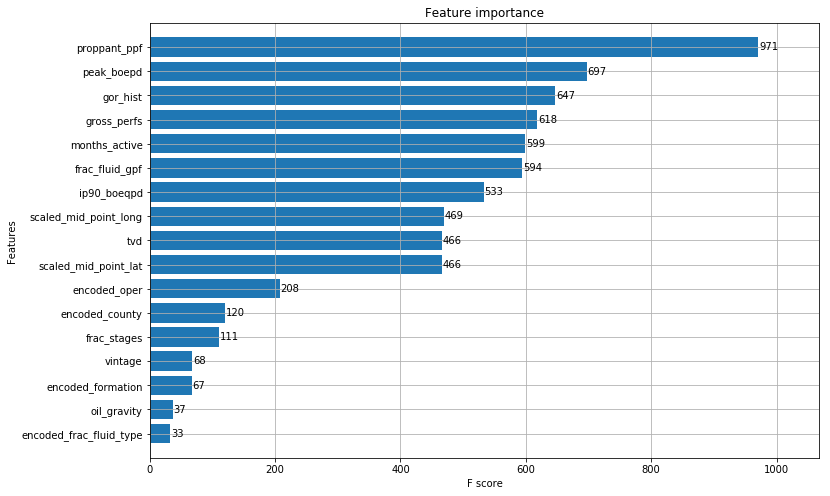

In [11]:
xgb_params = {
    'max_depth': 8,
    'seed' : 493
}

dtrain = xgb.DMatrix(xgb_df, df.oil_hist, feature_names=xgb_df.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=50)

# plot the important features #
fig, ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

# Test Harness and Options

In [5]:
# xfeatures = ['proppant_ppf', 'frac_fluid_gpf', 'gor_hist', 'tvd', 'mid_point_lat', 'mid_point_long', 'encoded_oper', 'encoded_direction', 'vintage', 'gross_perfs']
# yfeature = ['recovery']

In [6]:
xfeatures = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 'gor_hist', 'encoded_oper', 'vintage']
yfeature = ['recovery']

In [7]:
df_normalize = model.normalize(df, xfeatures)

### Results for the entire dataframe to use as a baseline before clustering

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 124.54940279100616
R2 score of training set is 0.20132945506697697


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.19821579 0.19439958 0.20518695]


The model performance for the test set
-------------------------------------------
RMSE of test set is 129.41388142020216
R2 score of test set is 0.19378508558369023




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 123.73243266767476
R2 score of training set is 0.21177270064883325


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.20928341 0.20267311 0.21664497]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

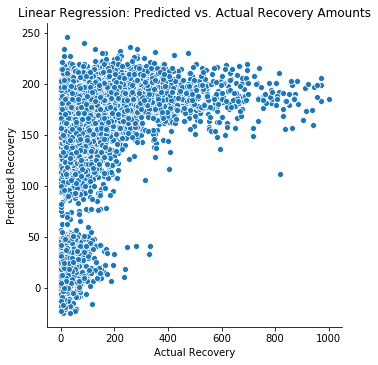

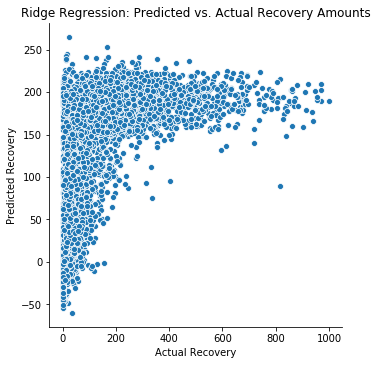

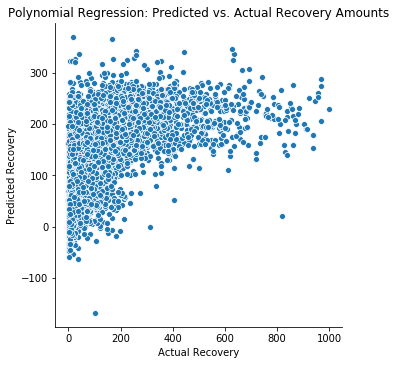

In [8]:
model.run_models(df, xfeatures, yfeature, 0.80)

**Let's Cluster by our Top Seven features per our XGBoost function**

In [9]:
# col_list = ['scaled_proppant_ppf', 'scaled_gross_perfs', 'scaled_tvd', 'scaled_frac_fluid_gpf', 
#             'scaled_gor_hist', 'encoded_oper', 'scaled_vintage']

In [10]:
col_list = ['proppant_ppf', 'gross_perfs', 'tvd', 'frac_fluid_gpf', 
            'gor_hist', 'encoded_oper', 'vintage']

**We now have a new dataframe with an added column "cluster_id"**

In [11]:
df = model.create_kclusters(df, col_list, 3, 'cluster_id')

**Let's see how many oberservations we have in each cluster**

In [12]:
df.cluster_id.value_counts()

0    4926
2    1729
1    1233
Name: cluster_id, dtype: int64

In [13]:
df.to_excel('CapstoneDataFinal.xlsx')

# ALL Regression Types on Each Cluster

### Cluster 0: 4,862 Oberservations 

In [14]:
cluster_zero = df[df['cluster_id'] == 0]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 133.45121428865585
R2 score of training set is 0.13770221973903407


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.13187045 0.14871874 0.12266283]


The model performance for the test set
-------------------------------------------
RMSE of test set is 152.39881127169335
R2 score of test set is 0.12131849003006823




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 133.34964114512155
R2 score of training set is 0.13901435413333962


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.13175861 0.14882963 0.12421365]


The model performance for the test set
-------------------------------------------
RMSE of test set is 

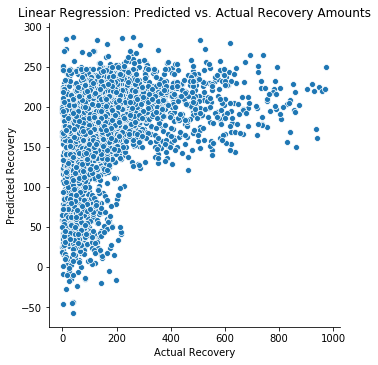

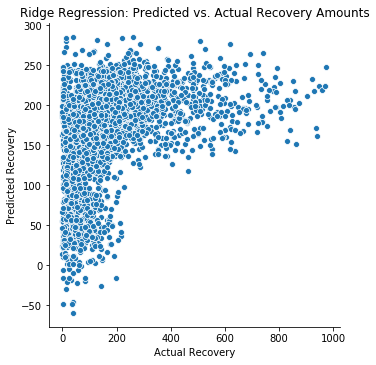

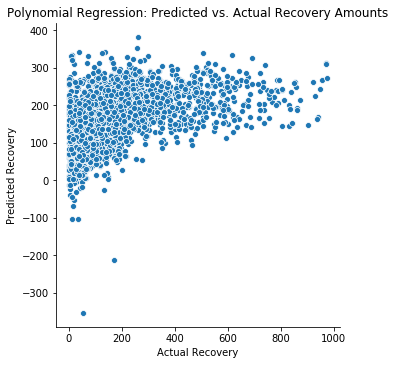

In [15]:
model.run_models(cluster_zero, xfeatures, yfeature, 0.70)

### Cluster 1: 1,714 Observations

In [16]:
cluster_one = df[df['cluster_id'] == 1]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 45.90723847747801
R2 score of training set is 0.14939211986015422


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.12691337 0.03708142 0.10785151]


The model performance for the test set
-------------------------------------------
RMSE of test set is 40.08203768428024
R2 score of test set is 0.14295721029238928




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 41.7865692850334
R2 score of training set is 0.29524121627966937


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.27969981 0.19053234 0.22653954]


The model performance for the test set
-------------------------------------------
RMSE of test set is 38.0

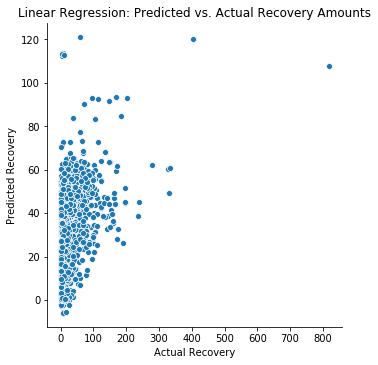

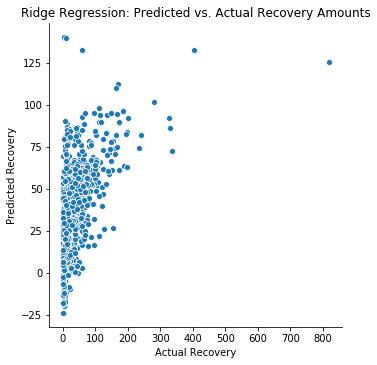

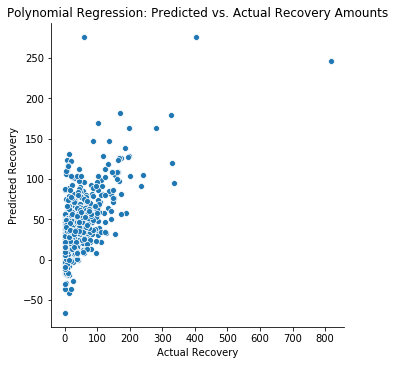

In [17]:
model.run_models(cluster_one, xfeatures, yfeature, 0.70)

### Cluster 2: 1,232 Observations

In [18]:
cluster_two = df[df['cluster_id'] == 2]

Linear Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 110.1469169960853
R2 score of training set is 0.13342191068667375


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.13918616 0.11210547 0.11717479]


The model performance for the test set
-------------------------------------------
RMSE of test set is 120.10517263610515
R2 score of test set is 0.12591946762260087




Ridge Regression Model:
The model performance for the training set
-------------------------------------------
RMSE of training set is 110.07313664786172
R2 score of training set is 0.13458245192522345


The cross validation for the training set
-------------------------------------------
Cross Validation of training set is [0.14004248 0.11334236 0.11489254]


The model performance for the test set
-------------------------------------------
RMSE of test set is 1

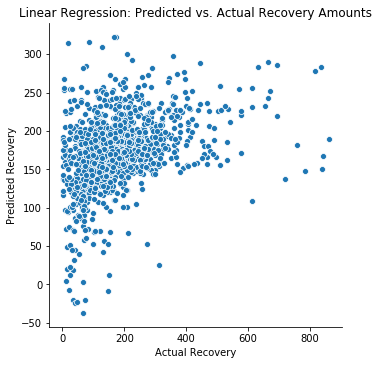

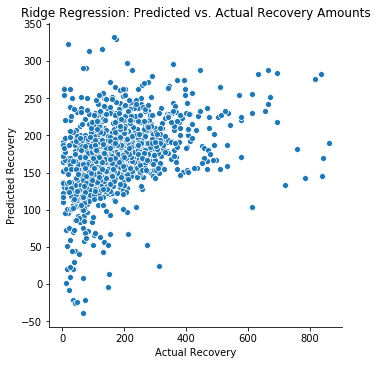

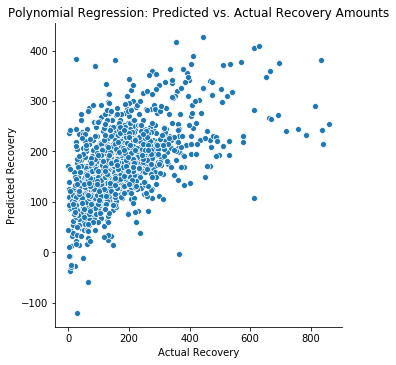

In [19]:
model.run_models(cluster_two, xfeatures, yfeature, 0.70)

## Interpret and report results

# Improve Results

## Algorithm Tuning

## Ensemble Methods

### Bagging

### Boosting

### Blending

## Extreme Feature Engineering